# NRC-24 Dither Pattern Verification

The purpose of this activity is to verify that the dither patterns for NIRCam imaging execute properly. Images of the standard LMC astrometric calibration field in the CVZ (R.A. = 05:21:57, Dec = −69:29:51) are recorded using three primary dither patterns and three secondary dither patterns. The large number of stars in the LMC field allows precise measurements of the executed dither offsets and the field-overlap between dither positions.  

The primary-pattern test comprises two “full-field” dither patterns (“FULLBOX”, using "8NIRSpec" and "4 point") and one “intra-module” dither pattern (4 points).  The secondary-pattern test consists of 3 “subpixel” dither patterns (2, 4 and 9 points). One combination of the "INTRAMODULEBOX" 4-point primary dither pattern and a 2-point subpixel dither pattern is also tested. 

The F150W and F277W filters are used in the primary-pattern and NIRSpec pre-imaging tests for maximum source sensitivity.  The pairs of wide SW and LW filters used in the secondary (subpixel) pattern tests depend on the density of the dither points, such that shorter wavelength filters are matched with larger numbers of dithers to better sample the PSF.

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Enable inline plotting at lower left
%matplotlib inline

# Load progress bars
from tqdm.auto import trange, tqdm

In [2]:
import os
from astropy.io import ascii

import pynrc
from pynrc import nrc_utils, nircam_cal, DMS_input, DetectorOps
from pynrc.simul.apt import get_detname, gen_pointing_info
from pynrc.simul.ngNRC import sources_to_level1b, sources_to_slope, create_level1b_FITS

from datetime import datetime

pynrc.setup_logging('WARN', verbose=False)

# Read in LMC catalog

In [3]:
# Read in master source table and FITS file
cat_file = '../LMC_catalogs/lmc_catalog_flag1.cat'
names = [
    'index', 'ra', 'dec', 'F070W', 'F090W', 'F115W', 'F140M', 'F150W', 'F150W2',
    'F162M', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 
    'F300M','F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 
    'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

src_tbl = ascii.read(cat_file, names=names)

In [4]:
# params_disk_model = {
#     'file': '/Users/jarron/NIRCam/DebrisDisk_models_v2/HD10647/HD10647_F300Msc.fits',
#     'pixscale': 0.01575,
#     'dist': 17.34,
#     'wavelength': 3.0,
#     'units': 'Jy/pixel',
#     'cen_star': True,
#     'npsfs_per_axis': 9,
# }

params_disk_model = None

# Create Observation Parameters

These will used for input into the data ramp simulator and directly correspond to parameters for DMS FITS creation to ingest into the JWST pipeline

In [5]:
com_str = 'NRC-24'

sim_config = {
    # APT input files
    'json_file'     : f'{com_str}.timing.json',
    'sm_acct_file'  : f'{com_str}.smart_accounting',
    'pointing_file' : f'{com_str}.pointing',
    'xml_file'      : f'{com_str}.xml',
    # Output directory
    'save_dir'      : '/Users/jarron/NIRCam/Data/Sim_NRC24/',   
    
    # Date and time of observations
    'obs_date' : '2022-03-01', 
    'obs_time' : '12:00:00',
    # Position angle of observatory
    # User should check acceptable range in APT's Roll Analysis
    'pa_v3'    : 0,
    
    # Source information
    'src_tbl'   : src_tbl,  # source table with RA, Dec, and filter mags
    'params_disk_model' : params_disk_model,

    
    # PSF size information for WebbPSF_ext
    'params_webbpsf' : {'fov_pix': 257, 'oversample': 2},
    # Position-dependent PSFs for convolution
    'params_psfconv' : {'npsf_per_full_fov': 5, 'osamp': 1, 'sptype': 'G0V'},
    # Wavefront error drift settings
    'enable_wfedrift' : False,
    # For coronagraphic masks, sample large grid of points?
    'large_grid' : True,
    
    # Slew and dither pointing uncertainties
    'large_slew' : 100.0,   # Slew to target (mas)
    'ta_sam'     : 5.0,     # SAM movements from TA position (mas)
    'std_sam'    : 5.0,     # Standard dither values (mas)
    'sgd_sam'    : 2.5,     # Small grid dithers (mas)
    
    # Type of image files to save
    'save_slope' : False,  # Save ideal noiseless slope images to FITS
    'save_dms'   : True,   # Save DMS-like ramps to FITS
    'dry_run'    : False,  # Perform a dry-run, not generating any data, just printing visit info

    # Random seeds
    'dith_seed_init' : 1234, 
    
    # Ramp parameters
    'params_noise' : {
        'include_dark'      : True,     # Dark current
        'include_bias'      : True,     # Bias image offset
        'include_ktc'       : True,     # kTC Noise
        'include_rn'        : True,     # Read Noise
        'include_cpink'     : True,     # Correlated 1/f noise between channel
        'include_upink'     : True,     # Channel-dependent 1/f noise
        'include_acn'       : True,     # Alternating column noise
        'apply_ipc'         : True,     # Interpixel capacitance
        'apply_ppc'         : True,     # Post-pixel coupling
        'amp_crosstalk'     : True,     # Amplifier crosstalk
        'include_refoffsets': True,     # Reference offsets
        'include_refinst'   : True,     # Reference pixel instabilities
        'include_colnoise'  : False,    # Transient detector column noise
        'add_crs'           : False,    # Include cosmic ray
        'cr_model'          : 'SUNMAX', # Cosmic ray model ('SUNMAX', 'SUNMIN', or 'FLARES')
        'cr_scale'          : 1,        # Cosmic ray probabilities scaling
        'apply_nonlinearity': True,     # Apply non-linearity
        'random_nonlin'     : True,     # Add randomness to non-linearity
    },
}

In [6]:
json_file     = sim_config['json_file']
sm_acct_file  = sim_config['sm_acct_file']
pointing_file = sim_config['pointing_file']
xml_file      = sim_config['xml_file']
save_dir      = sim_config['save_dir']

# Source information
src_tbl   = sim_config['src_tbl']
disk_hdul = sim_config['disk_hdul']

# PSF information
kwargs_nrc = sim_config['params_webbpsf']
kwargs_psf = sim_config['params_psfconv']
enable_wfedrift = sim_config['enable_wfedrift']
kwargs_det = sim_config['params_noise']

large_slew_uncert = sim_config['large_slew']
ta_sam_uncert     = sim_config['ta_sam']
std_sam_uncert    = sim_config['std_sam']
sgd_sam_uncert    = sim_config['sgd_sam']

save_slope = sim_config['save_slope']
save_dms = sim_config['save_dms']
dry_run = sim_config['dry_run']

#################################################
# Create DMS Input class
obs_input = DMS_input(xml_file, pointing_file, json_file, sm_acct_file, save_dir=save_dir)

# Update observing start date/time and V3 PA
obs_input.obs_date = sim_config['obs_date']
obs_input.obs_time = sim_config['obs_time']
obs_input.pa_v3    = sim_config['pa_v3']

# Generate all observation parameters for every visit, exposure, detector, etc
obs_params_all = obs_input.gen_all_obs_params()
obs_params_all = np.asarray(obs_params_all)

Obs Params:   0%|          | 0/470 [00:00<?, ?it/s]

In [9]:
obs_input.program_info['002:001']

{'obs_num': 2,
 'visit_num': 1,
 'exp_start_times': array([2494, 2684, 3030, 3220]),
 'PrimaryDitherType': array(['FULLBOX', 'FULLBOX', 'FULLBOX', 'FULLBOX'], dtype='<U14'),
 'PrimaryDithers': array(['4', '4', '4', '4'], dtype='<U8'),
 'SubpixelPositions': array(['1', '1', '1', '1'], dtype='<U1'),
 'SubpixelDitherType': array(['STANDARD', 'STANDARD', 'STANDARD', 'STANDARD'], dtype='<U8'),
 'DitherPatternType': array(['None', 'None', 'None', 'None'], dtype='<U4'),
 'ImageDithers': array(['None', 'None', 'None', 'None'], dtype='<U4'),
 'number_of_dithers': array(['4', '4', '4', '4'], dtype='<U1'),
 'dith_rand_seed': 3970260357,
 'aperture': array(['NRCALL_FULL', 'NRCALL_FULL', 'NRCALL_FULL', 'NRCALL_FULL'],
       dtype='<U11'),
 'pri_dith': array([1, 2, 3, 4]),
 'sub_dith': array([1, 1, 1, 1]),
 'targ1': array([1, 1, 1, 1]),
 'targ2': array(['LMC-ASTR', 'LMC-ASTR', 'LMC-ASTR', 'LMC-ASTR'], dtype='<U8'),
 'ra': array([80.4875, 80.4875, 80.4875, 80.4875]),
 'dec': array([-69.4975, -69.497

In [7]:
obs_params_all[0]

{'pi_name': 'Anton Koekemoer',
 'title': 'NIRCam Dither Pattern Verification',
 'category': 'GO',
 'sub_category': 'UNKNOWN',
 'science_category': 'Planets and Planet Formation',
 'target_name': 'LMC-ASTR',
 'catalog_name': 'UNKNOWN',
 'ra': 80.4875,
 'dec': -69.4975,
 'pa_v3': 0,
 'siaf_ap': <pysiaf.Aperture object AperName=NRCA1_FULL >,
 'ra_obs': 80.56403749527621,
 'dec_obs': -69.50360688832227,
 'siaf_ap_ref': <pysiaf.Aperture object AperName=NRCALL_FULL >,
 'ra_ref': 80.46817193547295,
 'dec_ref': -69.49401778051002,
 'date-obs': '2022-03-01',
 'time-obs': '12:00:00',
 'obs_id_info': {'program_number': '01073',
  'observation_number': '002',
  'visit_number': '001',
  'visit_group': '01',
  'sequence_id': '1',
  'activity_id': '01',
  'exposure_number': '00001',
  'visit_id': '01073002001',
  'obs_id': 'V01073002001P0000000001101'},
 'obs_label': 'FULLBOX 4',
 'det_obj': <pynrc.pynrc_core.DetectorOps at 0x7f9360107d50>,
 'module': 'A',
 'channel': 'SHORT',
 'detector': 'NRCA1',
 

In [ ]:
create_level1b_FITS(sim_config, detname='NRCA5', apname='NRCA5_FULL', filter='F277W', visit_id='007:001')

In [ ]:
def obs_params_to_slope_image(obs_params, tel_pointing, hdul_psfs=None, **kwargs):
    
    # Create NIRCam instrument object
    filt  = obs_params['filter']
    pupil = None if obs_params['pupil']=='CLEAR'     else obs_params['pupil']
    mask  = None if obs_params['coron_mask']=='None' else obs_params['coron_mask']
    ap_obs_name = obs_params['siaf_ap'].AperName
    
    # Create grid of PSFs
    if hdul_psfs is None:
        # Create NIRCam PSf
        
        kwargs_psf = {'npsf_per_full_fov': 5, 'osamp': 1, 'wfe_drift': 0, 'sptype': 'G0V'}
        # Merg dictionaries and update anything passed through
        kwargs_psf = {**kwargs_psf, **kwargs}
        hdul_psfs = nrc.gen_psfs_over_fov(**kwargs_psf)

First, we create a telescope pointing class that holds all the pointing and dither information for a given visit. The pointing class allows us to specify telescope slew and dither uncertainties. 

**CAUTION**: A single pointing class only specifes one detector. However, random pointing offsets should be consistent across multiple detectors that are exposed at the same time. In the case of multiple detectors, make sure to use the same random seed. If the user does nothing, this should all happen automatically for a given `obs_input` obect

In [9]:
# Choose a visit, exposure ID, and detector
# Create JWST pointing object and observation info
visit_id = '007:001'  # obsnum:visitnum
expnum = 16
detname = 'NRCA5'

tel_pointing = obs_input.make_jwst_point(visit_id, detname, base_std=0, dith_std=0)
obs_params = obs_input.gen_obs_param(visit_id, expnum, detname)

In [11]:
# Create NIRCam PSF generator
filt  = obs_params['filter']
pupil = None if obs_params['pupil']=='CLEAR' else obs_params['pupil']
ap_obs_name = obs_params['siaf_ap'].AperName

nrc = pynrc.NIRCam(filter=filt, apname=ap_obs_name, fov_pix=513, oversample=2)
nrc.gen_wfefield_coeff()
nrc.gen_wfedrift_coeff()

In [12]:
# Create grid of PSFs
kwargs = {'npsf_per_full_fov': 5, 'osamp': 1, 'wfe_drift': 0, 'sptype': 'G0V'}
hdul_psfs = nrc.gen_psfs_over_fov(**kwargs)

PSFs:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# Add zodiacal background
from datetime import datetime

ra_ref = obs_params['ra_ref']
dec_ref = obs_params['dec_ref']

# Get Zodiacal background emission.
# Can be reused for all ints in same observation.
try:
    im_bg = im_bg
except NameError:
    date_str = obs_params['date-obs']
    date_arg = (int(s) for s in date_str.split('-'))
    day_of_year = datetime(*date_arg).timetuple().tm_yday
    im_bg = nrc.bg_zodi_image(ra=ra_ref, dec=dec_ref, thisday=day_of_year)

In [21]:
import pysiaf
import os

import webbpsf_ext
from webbpsf_ext import coords
from webbpsf_ext import robust
from webbpsf_ext.utils import S
from webbpsf_ext.coords import jwst_point
from webbpsf_ext.image_manip import convolve_image, frebin

import pynrc
from pynrc import conf
from pynrc import nrc_utils
from pynrc.simul.apt import DMS_input
from pynrc.simul.ngNRC import simulate_detector_ramp
from pynrc.simul.dms import create_DMS_HDUList, update_dms_headers
from pynrc.reduce.calib import nircam_cal
from pynrc.nrc_utils import gen_unconvolved_point_source_image

from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u

pynrc.setup_logging('WARN', verbose=False)

In [8]:
# Create NIRCam PSF generator
filt  = obs_params['filter']
pupil = None if obs_params['pupil']=='CLEAR' else obs_params['pupil']
ap_obs_name = obs_params['siaf_ap'].AperName

nrc = pynrc.NIRCam(filter=filt, apname=ap_obs_name, fov_pix=513, oversample=2)
nrc.gen_wfefield_coeff()
nrc.gen_wfedrift_coeff()

In [9]:
# Create grid of PSFs
kwargs = {'npsf_per_full_fov': 5, 'osamp': 1, 'wfe_drift': 0, 'sptype': 'G0V', 'save_dir': None}

res = gen_psfs_over_fov(nrc, **kwargs)
hdul_psfs = res[-1]

PSFs:   0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
# Add zodiacal background
from datetime import datetime

ra_ref = obs_params['ra_ref']
dec_ref = obs_params['dec_ref']

# Get Zodiacal background emission.
# Can be reused for all ints in same observation.
try:
    im_bg = im_bg
except NameError:
    date_str = obs_params['date-obs']
    date_arg = (int(s) for s in date_str.split('-'))
    day_of_year = datetime(*date_arg).timetuple().tm_yday
    im_bg = nrc.bg_zodi_image(ra=ra_ref, dec=dec_ref, thisday=day_of_year)

In [11]:
det = obs_params['det_obj']
caldir = os.path.join(conf.PYNRC_PATH, 'calib', str(det.scaid))
cal_obj = nircam_cal(det.scaid, caldir, verbose=False)

[     pynrc:INFO] Generating initial super bias
[     pynrc:INFO] Creating super dark ramp cube, updated super bias, and pixel mask info
[     pynrc:INFO] Calculating dark slope image...
[     pynrc:INFO] Calculating average pixel ramps...
[     pynrc:INFO] Building CDS Noise dictionaries...
[     pynrc:INFO]   Best fit excess variance model parameters: [1.41538086 7.78820252]
[     pynrc:INFO] Calculating kTC Noise for active and reference pixels...
[     pynrc:INFO] Building noise power spectrum dictionary...
[     pynrc:INFO] Calculating IPC and PPC kernels...
[     pynrc:INFO]   IPC = 0.597% +/- 0.004%
[     pynrc:INFO]   PPC = 0.123% +/- 0.010%
[     pynrc:INFO] Deconvolving super dark and super bias images...


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

[     pynrc:INFO] Determining column variations (RTN)
[     pynrc:INFO] Determining reference pixel behavior
[     pynrc:INFO] Loading non-linearity coefficents


In [23]:
obspar_to_level1b(obs_params, tel_pointing, nrc, src_tbl, cal_obj=cal_obj,
                  hdul_psfs=hdul_psfs, im_bg=im_bg, **kwargs)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Frames:   0%|          | 0/8 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

Generating: pynrc_jw01073007001_01101_00016_nrca5_uncal.fits


In [6]:
# Choose a visit, exposure, and detector
visit_id = '007:001'  # obsnum:visitnum
expnum = 1  # dither position
detname = 'NRCA5'
# visit_dict = obs_input.program_info[visit_id]

obs_params = obs_input.gen_obs_param(visit_id, expnum, detname)
label = obs_input.gen_label(visit_id, expnum, detname)

## Plot stars in focal plane

We want to use pysiaf to grab the telescope (V2/V3) coordinates of the NIRCam detectors as projected on the sky. We will then transform all of the RA/Dec info into V2/V3 coords for our catalog of stars assuming the telescope is pointed at a specific RA/Dec and oriented with a certain position angle.

In [9]:
# Get the WCS coordinate system for plotting
hdul = fits.open('../LMC_catalogs/LMC Calibration Field 2020/LMC_JWSTCAL_2017.fits')
hdu = hdul[0]
# Set up a WCS for for the image
wcs = WCS(hdu.header)
hdul.close()

In [10]:
# Turn RA/Dec fields into Skycoords object
ra_obj, dec_obj = (src_tbl['ra'], src_tbl['dec'])
obj_coords = SkyCoord(ra_obj, dec_obj, unit=u.deg, frame='icrs')

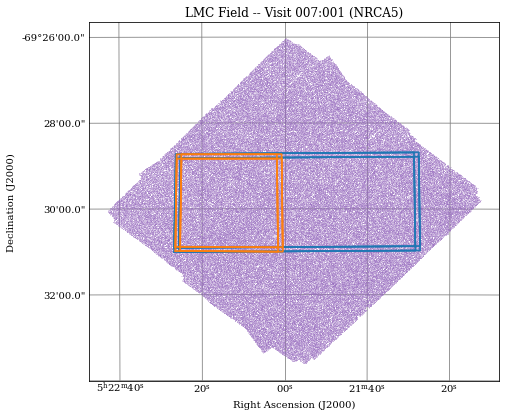

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,5.5))

ax = plt.subplot(projection=wcs)
ax.plot_coord(obj_coords, ls='none', marker=',', alpha=0.25, color='C4')

ax.coords.grid(color='gray', linestyle='solid')
lon = ax.coords[0]
lat = ax.coords[1]

lon.set_axislabel('Right Ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
lon.set_major_formatter('hh:mm:ss')
lat.set_major_formatter('dd:mm:ss.s')
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)

# Convert aperture V2/V3 vertices to RA/Dec
carr = ['C0', 'C1']
for i, siaf_ap in enumerate([tel_pointing.siaf_ap_ref, tel_pointing.siaf_ap_obs]):
    for idl_off in tel_pointing.position_offsets_act:
        ra_ap, dec_ap = tel_pointing.ap_radec(idl_off=idl_off, get_cenpos=False, get_vert=True, 
                                              ap_siaf_obs=siaf_ap)
        ap_coord = SkyCoord(ra_ap, dec_ap, unit='deg', frame='icrs')
        ax.plot_coord(ap_coord, color=carr[i], alpha=0.5)
    
title = f'LMC Field -- Visit {visit_id} ({detname})'
ax.set_title(title)
    
fig.tight_layout()

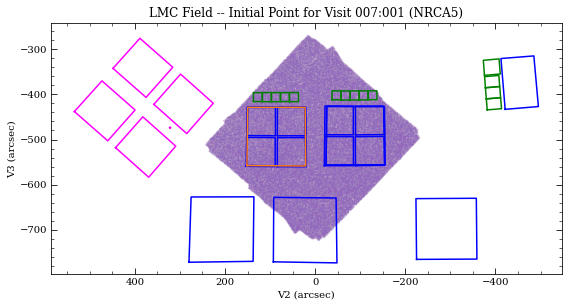

In [12]:
# Convert RA, Dec coordiantes into V2/V3 (arcsec)
ra_deg  = obj_coords.ra.deg
dec_deg = obj_coords.dec.deg
idl_off = [tel_pointing.position_offsets_act[0]]
v2_obj, v3_obj = tel_pointing.radec_to_frame((ra_deg, dec_deg), frame_out='tel', idl_offsets=idl_off)

# Plot aperture files
fig, ax = plt.subplots(1,1)

# V2/V3 positions of all objects
ax.scatter(v2_obj, v3_obj, s=1, marker='.', alpha=0.1, color='C4')

# Plot all the telescope aperture (NIRCam, NIRSpec, NIRIS, MIRI, and FGS)
tel_pointing.plot_main_apertures(ax=ax)

# Plot the 
tel_pointing.plot_obs_aperture(ax=ax, color='C1')

title = f'LMC Field -- Initial Point for Visit {visit_id} ({detname})'
ax.set_title(title)
fig.tight_layout()

# Simulate Field

In [11]:
# Select an exposure, detector, and corresponding filter
expnum = 16
obs_params = obs_input.gen_obs_param(visit_id, expnum, detname)

filt  = obs_params['filter']
pupil = None if obs_params['pupil']=='CLEAR' else obs_params['pupil']
ap_obs_name = obs_params['siaf_ap'].AperName

print(visit_id, expnum, detname, filt, pupil, ap_obs_name)

007:001 16 NRCA5 F277W None NRCA5_FULL


In [12]:
print(obs_params.keys())

dict_keys(['pi_name', 'title', 'category', 'sub_category', 'science_category', 'target_name', 'catalog_name', 'ra', 'dec', 'pa_v3', 'siaf_ap', 'ra_obs', 'dec_obs', 'siaf_ap_ref', 'ra_ref', 'dec_ref', 'obs_id_info', 'obs_label', 'date-obs', 'time-obs', 'module', 'channel', 'detector', 'filter', 'pupil', 'exp_type', 'subarray_name', 'xstart', 'ystart', 'xsize', 'ysize', 'fastaxis', 'slowaxis', 'readpatt', 'nframes', 'ngroups', 'nints', 'sample_time', 'frame_time', 'group_time', 'groupgap', 'nresets1', 'nresets2', 'integration_time', 'exposure_time', 'tint_plus_overhead', 'texp_plus_overhead', 'texp_start_relative', 'int_times', 'integration_start', 'integration_end', 'group_times', 'primary_type', 'position_number', 'total_points', 'dither_points', 'pattern_size', 'subpixel_type', 'subpixel_number', 'subpixel_total_points', 'x_offset', 'y_offset', 'EXSEGNUM', 'EXSEGTOT', 'pid', 'filename', 'visit_key'])


In [13]:
nrc = pynrc.NIRCam(filter=filt, apname=ap_obs_name, fov_pix=513, oversample=2)
nrc.gen_wfefield_coeff()
nrc.gen_wfedrift_coeff()

In [14]:
# Update pynrc class from file info 
from pynrc.simul.apt import create_det_class
det = create_det_class(visit_dict, expnum, nrc.Detector.detid)
kwargs = det.to_dict()
kwargs.update(det.multiaccum.to_dict())
nrc.update_detectors(verbose=True, **kwargs)

New Ramp Settings
  read_mode  :  BRIGHT2
  nf         :        2
  nd2        :        0
  ngroup     :        4
  nint       :        1
New Detector Settings
  wind_mode  :     FULL
  xpix       :     2048
  ypix       :     2048
  x0         :        0
  y0         :        0
New Ramp Times
  t_group    :   21.474
  t_frame    :   10.737
  t_int      :   85.894
  t_int_tot1 :   85.894
  t_int_tot2 :    0.000
  t_exp      :   85.894
  t_acq      :   85.899


## Grid of PSFs across the field of view

The grid of PSFs can potentially be used for multiple dither positions of the same filter/detector, assuming the same WFE drift value.

In [58]:


osamp = 1     # Set sampling of PSF and convolution
res = gen_psfs_over_fov(nrc, npsf_per_full_fov=5, osamp=osamp, sptype='G0V')
xsci_psf, ysci_psf, hdul_psfs = res

PSFs:   0%|          | 0/25 [00:00<?, ?it/s]

### Create dither position image

In [ ]:
kwargs = {'npsf_per_full_fov': 5, 'osamp': 1, 'wfe_drift': 0, 'sptype': 'G0V', 'save_dir': None}
# kwargs = {
#     'include_dark': True, 'include_bias': True, 'include_ktc': True, 
#     'include_rn': True, 'include_cpink': True, 'include_upink': True, 
#     'include_acn': False, 'apply_ipc': True, 'apply_ppc': True,
#     'include_refoffsets': True, 'include_refinst': True, 
#     'include_colnoise': True, 'col_noise': None, 'amp_crosstalk': True,
#     'add_crs': True, 'cr_model': 'SUNMAX', 'cr_scale': 1,
#     'latents': None, 'apply_nonlinearity': True, 'random_nonlin': False,
#     'cframe': 'sci', 'out_ADU': True, 'return_full_ramp': False,
# }

res = gen_psfs_over_fov(nrc, **kwargs)
hdul_psfs = res[-1]

In [16]:
# ra_deg = np.array([80.6, 80.52, 80.6, 80.52, 80.56])
# dec_deg = np.array([-69.481, -69.481, -69.512, -69.512, -69.496])
# mags = 18 * np.ones_like(ra_deg)
# print(tel_pointing.radec_to_frame((ra_deg, dec_deg), frame_out='sci', idl_offsets=idl_off))

# RA and Dec of all objects in field
ra_deg, dec_deg = (src_tbl['ra'], src_tbl['dec'])
# Vega magnitude values
mags = src_tbl[nrc.filter].data
hdul_sci_image = gen_unconvolved_point_source_image(nrc, tel_pointing, ra_deg, dec_deg, mags, 
                                                    expnum=expnum, osamp=osamp)

# Perform convolution
hdul_sci_conv = convolve_image(hdul_sci_image, hdul_psfs, output_sampling=1, return_hdul=True)
ny, nx = hdul_sci_conv[0].data.shape
xsci = np.arange(nx) + hdul_sci_conv[0].header['XSCI0']
ysci = np.arange(ny) + hdul_sci_conv[0].header['YSCI0']

  0%|          | 0/25 [00:00<?, ?it/s]

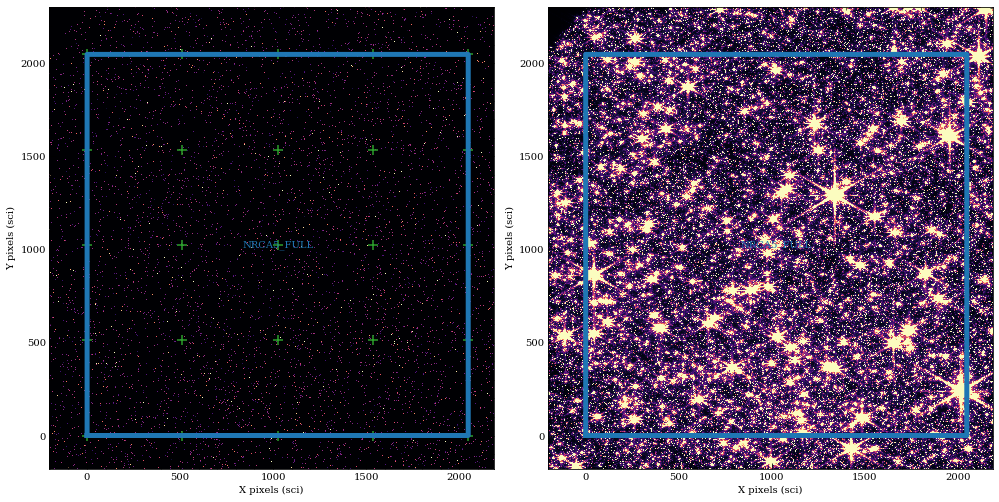

In [17]:
fig, axes = plt.subplots(1,2, figsize=(14,7))

extent = [xsci.min(), xsci.max(), ysci.min(), ysci.max()]

im_sci  = hdul_sci_image[0].data
im_conv = hdul_sci_conv[0].data
for i, im in enumerate([im_sci**0.2, im_conv]):
    ax = axes[i]

    ind = im!=0
    med = np.median(im[ind])
    std = robust.medabsdev(im[ind])
    vmin, vmax = med + 5*std*np.array([-1,1])
    ax.imshow(im, extent=extent, vmin=0, vmax=vmax, cmap='magma')

    tel_pointing.plot_obs_aperture(frame='sci', ax=ax, label=True, color='C0', lw=5)

    if i==0:
        ax.scatter(xsci_psf.flatten(), ysci_psf.flatten(), marker='+', color='C2', s=100)
        
#     ax.set_xlim([994,1000])
#     ax.set_ylim([1069,1075])

#     ax.set_xlim([0,100])
#     ax.set_ylim([0,100])
        
fig.tight_layout()

## Ramp Simulation

In [18]:
from pynrc.simul.ngNRC import simulate_detector_ramp, gen_ramp_biases

In [19]:
# Add zodiacal background
from datetime import datetime

# Get Zodiacal background emission.
# Can be reused for all ints in same observation.
try:
    im_bg = im_bg
except NameError:
    date_str = obs_params['date-obs']
    date_arg = (int(s) for s in date_str.split('-'))
    day_of_year = datetime(*date_arg).timetuple().tm_yday
    im_bg = nrc.bg_zodi_image(ra=ra_ref, dec=dec_ref, thisday=day_of_year)

[     pynrc:ERROR] Cannot reach JWST Background servers. Reverting to `zfact` input.


In [20]:
# Crop out relevant region and add background
xind = (xsci>=0) & (xsci<siaf_ap.XSciSize)
yind = (ysci>=0) & (ysci<siaf_ap.YSciSize)
im_slope = im_conv[yind,:][:,xind] + im_bg

In [21]:
det = nrc.Detector

In [22]:
caldir='/Users/jarron/NIRCam/dark_analysis/CV3/'
cal_obj = nircam_cal(det.scaid, caldir)

[     pynrc:INFO] Generating initial super bias
[     pynrc:INFO] Creating super dark ramp cube, updated super bias, and pixel mask info
[     pynrc:INFO] Calculating dark slope image...
[     pynrc:INFO] Calculating average pixel ramps...
[     pynrc:INFO] Building CDS Noise dictionaries...
[     pynrc:INFO]   Best fit excess variance model parameters: [1.41538086 7.78820252]
[     pynrc:INFO] Calculating kTC Noise for active and reference pixels...
[     pynrc:INFO] Building noise power spectrum dictionary...
[     pynrc:INFO] Calculating IPC and PPC kernels...
[     pynrc:INFO]   IPC = 0.597% +/- 0.004%
[     pynrc:INFO]   PPC = 0.123% +/- 0.010%
[     pynrc:INFO] Deconvolving super dark and super bias images...


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

[     pynrc:INFO] Determining column variations (RTN)
[     pynrc:INFO] Determining reference pixel behavior
[     pynrc:INFO] Loading non-linearity coefficents


In [23]:
tarr = det.times_group_avg
tarr.max()

ind = im_slope < (100000 / tarr.max())
iy, ix = np.argwhere(im_slope==np.max(im_slope[ind]))[0]

In [24]:
print(iy,ix)

1675 1230


In [25]:
%%time

kwargs = {
    'include_dark': True, 'include_bias': True, 'include_ktc': True, 
    'include_rn': True, 'include_cpink': True, 'include_upink': True, 
    'include_acn': False, 'apply_ipc': True, 'apply_ppc': True,
    'include_refoffsets': True, 'include_refinst': True, 
    'include_colnoise': True, 'col_noise': None, 'amp_crosstalk': True,
    'add_crs': True, 'cr_model': 'SUNMAX', 'cr_scale': 1,
    'latents': None, 'apply_nonlinearity': True, 'random_nonlin': True,
    'cframe': 'sci', 'out_ADU': True, 'return_full_ramp': False,
}

res = simulate_detector_ramp(det, cal_obj, im_slope=im_slope, **kwargs)
sci_data, zero_data = res

  0%|          | 0/13 [00:00<?, ?it/s]

Frames:   0%|          | 0/8 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 23.1 s, sys: 3.21 s, total: 26.3 s
Wall time: 26.3 s


1241.3309152515415


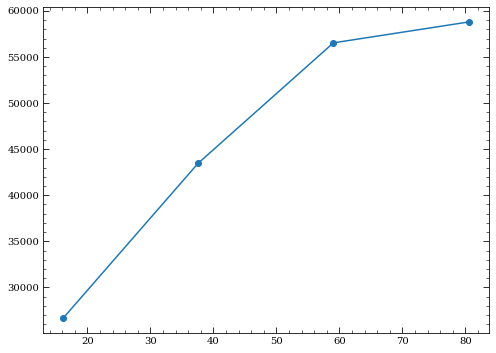

In [30]:
print(im_slope[iy,ix])
tarr_full = np.arange(1,sci_data.shape[0]+1) * det.time_frame

plt.plot(tarr, sci_data[:, iy, ix], marker='o')